In [1]:
#Import librarys
import os

import torch
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor

import torchvision.transforms as transforms
from torchvision import models

from torch.utils.data import Dataset

import numpy as np

In [2]:
#Locale where the imagens stay
image_path = 'images/'

#Getting the list of classes (considering each fold at "image_path" like a class)
list_classes = [f for f in os.listdir(image_path)]

num_classes = len(list_classes)

img_size = 224

In [4]:
#Data Transfor (Normalize the image values)
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandAugment(),
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

In [5]:
#Creating the class rensposable to load the imagens
class ImageDataset(Dataset):
    def __init__(self, list_classes, img_dir, transform=None, target_transform=None, remove_broken_images=False):
        """
        Define where the images stay, the classes of imagens and transformations that will be aplied.
        """
        #Creating the class variables
        self.list_classes = list_classes
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.remove_broken_images = remove_broken_images
        
        self.avaliable_images = []
        self.imagens = []
        
        #Loop for each class
        for select_class in self.list_classes:
            
            self.__imagens_in_folds__(select_class)

        
    def __len__(self):
        """
        Return the number of images (dataset size), this number are utilized
        in DataLoader to shuffle the data (to how how numbers can be selected).
        """
        return len(self.imagens)
    
    def __getitem__(self, idx):
        """
        Return a image and yout label.
        """
        select_sample = self.imagens[idx]

        select_class, image_path = select_sample.split('_')
        class_path = f"{self.img_dir}/{select_class}/"
        
        image = read_image(f"{class_path}{image_path}")
        label = list_classes.index(select_class)
        anchor_tensor = torch.zeros(3,img_size,img_size)
        
        if self.transform:
                 
            #Images with more that 3 channels are converted to 3 channel
            if image.shape[0] > anchor_tensor.shape[0]:
                image = torch.tensor(np.stack((image[0],image[1],image[2])))
                
            #Images less than 3 channel have the information triplicated
            else:
                image = torch.tensor(np.stack((image[0],image[0],image[0])))

            image = self.transform(image)
    
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label
    
    def __imagens_in_folds__(self, select_class):
        #Path with original fold and class
        class_path = f"{self.img_dir}{select_class}/"
        
        images_in_fold = os.listdir(f"{class_path}/")
        
        #Add at the list "class name"_"image name"
        [self.imagens.append(f"{select_class}_{image}") for image in images_in_fold]

In [7]:
#Instancin the dataset (giving the fold with images and list of classes)
remove_broken_images=True
training_dataset = ImageDataset(list_classes, image_path, transform, remove_broken_images=remove_broken_images)

In [8]:
#Testing the return of size the dataset
assert type(training_dataset.__len__()) == int, "The len must be a integer"

In [9]:
#Testing the return of datalaoder (two itens)
assert len(training_dataset.__getitem__(1)) == 2, "The return must by have 2 itens"

In [10]:
#Testing images with ore than 3 channels 9only use the first 3
assert len(training_dataset.__getitem__(6)) == 2, "The return must by have 2 itens"

## Creating a DataLoader

In [13]:
train_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True)

In [14]:
train_features, train_labels = next(iter(train_dataloader))

## Creating the Network

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
#Define if the pytorch will use cpu or gpu to training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [19]:
def GetModel():
    model = models.vgg16(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 256),nn.ReLU(inplace=True),
        nn.Linear(256, 128),nn.ReLU(inplace=True),
        nn.Linear(128, 64),nn.ReLU(inplace=True),
        nn.Linear(64, num_classes))

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    return(model.to(device), optimizer)

## Define the loss function

In [22]:
import torch.optim as optim

#Creating the model and the otimizer
model, optimizer = GetModel()

criterion = nn.CrossEntropyLoss()

In [23]:
#Sending to device the model and criterion
model.to(device)
criterion.to(device)

CrossEntropyLoss()

## Training the network

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [24]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 0:    # print every mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.001
[1,    11] loss: 0.008
[1,    21] loss: 0.008
[2,     1] loss: 0.001
[2,    11] loss: 0.007
[2,    21] loss: 0.006
[3,     1] loss: 0.000
[3,    11] loss: 0.005
[3,    21] loss: 0.005
[4,     1] loss: 0.000
[4,    11] loss: 0.004
[4,    21] loss: 0.004
[5,     1] loss: 0.000
[5,    11] loss: 0.004
[5,    21] loss: 0.004
[6,     1] loss: 0.000
[6,    11] loss: 0.004
[6,    21] loss: 0.003
[7,     1] loss: 0.000
[7,    11] loss: 0.003
[7,    21] loss: 0.003
[8,     1] loss: 0.000
[8,    11] loss: 0.003
[8,    21] loss: 0.003
[9,     1] loss: 0.000
[9,    11] loss: 0.003
[9,    21] loss: 0.003
[10,     1] loss: 0.000
[10,    11] loss: 0.003
[10,    21] loss: 0.002
[11,     1] loss: 0.000
[11,    11] loss: 0.002
[11,    21] loss: 0.003
[12,     1] loss: 0.000
[12,    11] loss: 0.002
[12,    21] loss: 0.002
[13,     1] loss: 0.000
[13,    11] loss: 0.002
[13,    21] loss: 0.002
[14,     1] loss: 0.000
[14,    11] loss: 0.002
[14,    21] loss: 0.002
[15,     1] loss: 0

In [25]:
model.eval()
PATH = './chess_model.pth'
torch.save(model.state_dict(), PATH)

## Predict image

In [27]:
import matplotlib.pyplot as plt

In [29]:
model, optimizer = GetModel()
model.load_state_dict(torch.load(PATH))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [40]:
img = read_image('cavalo.jpg')

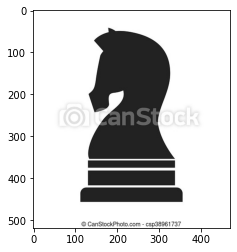

In [41]:
plt.imshow(img.permute(1, 2, 0))

In [42]:
# unsqueeze provides the batch dimension
img_tensor = transform(img).to('cuda').unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


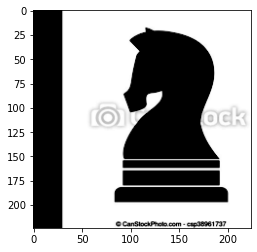

In [43]:
img2 = transform(img)
plt.imshow(img2.permute(1, 2, 0))

In [44]:
prediction = model(img2.unsqueeze(0).to('cuda'))

In [45]:
prediction

tensor([[ 0.3010,  5.0705, -3.1870, -2.1984,  0.1805]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [46]:
predicted_class = np.argmax(prediction[0].to('cpu').detach().numpy())
predicted_class

1

In [48]:
list_classes[predicted_class]

'KnightImages'